# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

c:\Users\victor.briones\Documents\python_virtual_enviroments\exploratory_data_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Librerías cargadas correctamente.


In [2]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2026/data_forecast_2026_silver/ingresos_membresia_ecobici_hsbc_limpio.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2024-12-20 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,6,5694.0,2024-12-20,5694.0
1,3,2847.0,2024-12-21,2847.0
2,5,4745.0,2024-12-22,4745.0
3,1,949.0,2024-12-23,949.0
4,1,949.0,2024-12-24,949.0


Filtro para obtener muestra de datos

In [3]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [4]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.05,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.fit(df)


14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [5]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

            ds
683 2026-11-26
684 2026-11-27
685 2026-11-28
686 2026-11-29
687 2026-11-30


Paso 5: Realizar la Predicción (Forecast)

In [6]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds          yhat    yhat_lower    yhat_upper
683 2026-11-26   8704.363246   5316.743170  12027.908710
684 2026-11-27  11507.285652   8259.540382  14688.973002
685 2026-11-28  12284.448788   8935.745643  15611.497419
686 2026-11-29  18385.484509  15016.795716  21786.360930
687 2026-11-30  12576.596038   9057.522986  15859.231305


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

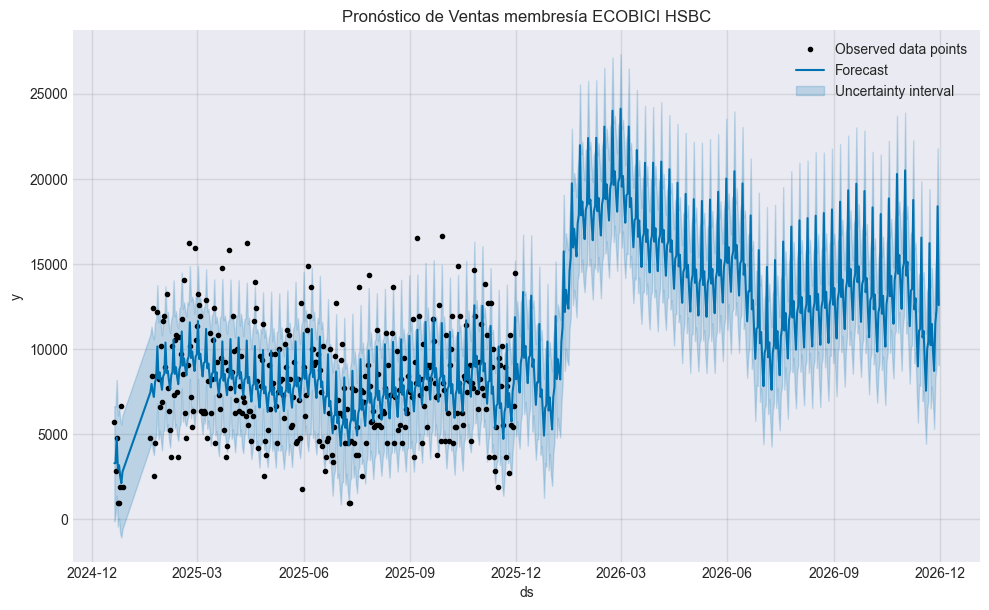

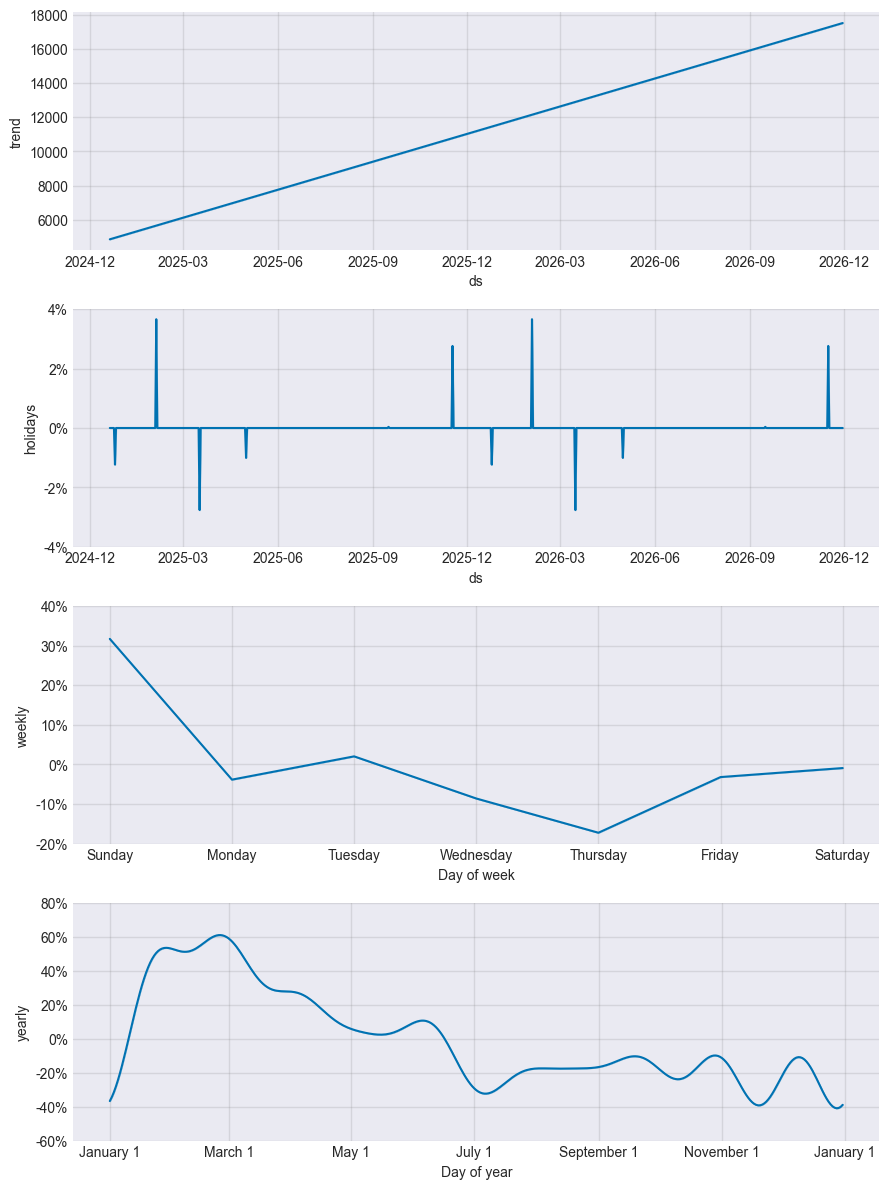

In [7]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas membresía ECOBICI HSBC")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

In [8]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("../data/data_forecast_2026/data_forecast_2026_gold/forecast_ecobici_hsbc_2026_daily.csv")

##### Agrupamos data por mes para su exportacion

In [9]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(2).reset_index()
print(monthly_sales)

      month       yhat  yhat_lower  yhat_upper
0   2024-12   24931.99    -1368.15    51677.98
1   2025-01   97530.56    56981.48   138325.12
2   2025-02  255400.97   162021.23   349037.16
3   2025-03  275527.82   170713.46   381745.64
4   2025-04  243985.75   142072.48   345952.95
5   2025-05  239913.32   134434.76   345324.76
6   2025-06  234948.28   133135.93   337658.73
7   2025-07  195557.28    91689.26   299668.35
8   2025-08  235717.50   131524.30   340104.37
9   2025-09  251500.74   150469.69   352035.80
10  2025-10  257086.35   152891.60   360148.27
11  2025-11  232764.05   132120.91   333865.63
12  2025-12  263726.89   159628.21   368955.16
13  2026-01  433493.84   327835.58   538415.98
14  2026-02  539082.57   444373.07   632595.81
15  2026-03  558530.13   454145.17   664459.76
16  2026-04  471718.05   371076.57   573468.46
17  2026-05  455757.66   350565.09   560843.96
18  2026-06  423460.73   321359.21   522920.30
19  2026-07  342934.29   238840.78   446725.16
20  2026-08  

In [10]:
monthly_sales.to_csv("../data/data_forecast_2026/data_forecast_2026_gold/forecast_ecobici_hsbc_2026_monthly.csv")

In [11]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

ValueError: Less data than horizon after initial window. Make horizon or initial shorter.